In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

NameError: name 'fetch_lfw_dataset' is not defined

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
from scipy.misc import imread,imresize
import pandas as pd
import scipy.io
import os
#import grading
import tarfile
import tqdm

Using TensorFlow backend.


1.2.1
2.0.6


In [4]:
IMG_SIZE = 250

from flower_dataset import decode_image_from_raw_bytes, prepare_raw_bytes_for_model, read_raw_from_tar, get_all_filenames

In [5]:
dx=10
dy=10
dimx=60
dimy=60

crop_ = lambda img:img[dy:-dy,dx:-dx]
resize_ = lambda img:imresize(img,[dimx,dimy])

def create_data(archieve_name, list_of_files):
    answ = []
    for ind, file_ in enumerate(list_of_files):
        if (ind%500 ==0):
            print (ind)
        img = imread(file_)
        #plt.imshow(img)
        #plt.show()
        b = crop_(img)
        b = resize_(b)
        answ.append(b)
        #plt.imshow(b)
        #plt.show()
    return answ
        

In [6]:
## enum files and read labels for each flower##
all_files = sorted(get_all_filenames("102flowers.tgz"))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  # read class labels (0, 1, 2, ...)
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)


## preprocess data ##
data = create_data("102flowers.tgz", all_files)

102
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000


In [7]:
## to array ##
data = np.array(data)
IMG_SHAPE = data.shape[1:]

See example of dataset 

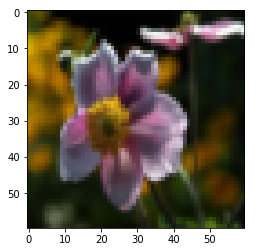

In [8]:
#print random image
plt.imshow(data[np.random.randint(len(data))], cmap="gray", interpolation="none")

In [9]:
!pip install tqdm

In [10]:
%env CUDA_VISIBLE_DEVICES=1

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

import keras
from keras.models import Sequential
from keras import layers as L

env: CUDA_VISIBLE_DEVICES=1


** Create Generator.**

1) We must encode (transfer in a space with different dimention) picture. Our dimention is 256

2) The output object size must correspond to the size of data image. 

In [11]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
print (generator.output_shape[1:])
generator.add(L.Dense(10*8*8, activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Reshape((8,8,10)))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(64,kernel_size=(5,5),activation='elu'))
print (generator.output_shape[1:])
generator.add(L.UpSampling2D(size=(2,2)))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=5,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Deconv2D(32,kernel_size=3,activation='elu'))
print (generator.output_shape[1:])
generator.add(L.Conv2D(3,kernel_size=3,activation=None))
print (generator.output_shape[1:])


(256,)
(640,)
(8, 8, 10)
(12, 12, 64)
(16, 16, 64)
(32, 32, 64)
(34, 34, 32)
(36, 36, 32)
(38, 38, 32)
(40, 40, 32)
(42, 42, 32)
(44, 44, 32)
(46, 46, 32)
(48, 48, 32)
(50, 50, 32)
(52, 52, 32)
(54, 54, 32)
(58, 58, 32)
(60, 60, 32)
(62, 62, 32)
(60, 60, 3)


** Check it **

In [12]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [13]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))
discriminator.add(L.Conv2D(32,kernel_size=3,activation='relu'))
discriminator.add(L.Conv2D(32,kernel_size=3,activation='relu'))
discriminator.add(L.MaxPool2D(pool_size=(2,2)))
discriminator.add(L.Conv2D(64,kernel_size=3,activation='relu'))
discriminator.add(L.Conv2D(64,kernel_size=3,activation='relu'))
discriminator.add(L.MaxPool2D(pool_size=(2,2)))
discriminator.add(L.Conv2D(128,kernel_size=3,activation='relu'))
discriminator.add(L.Conv2D(128,kernel_size=3,activation='relu'))
discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


In [14]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)
logp_gen = discriminator(generated_data)

########################
#discriminator training#
########################
d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

    

In [15]:
s.run(tf.global_variables_initializer())

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [16]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

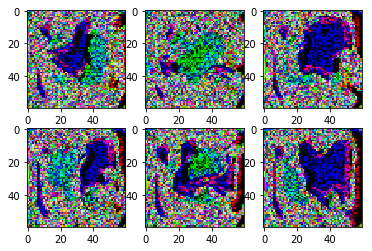

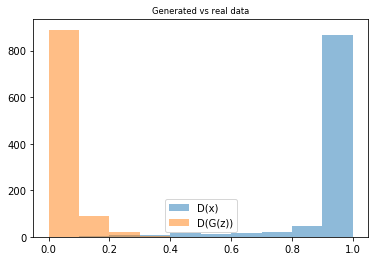

In [ ]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(3):
        s.run(disc_optimizer,feed_dict)
        
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        